# Proper Orthogonal Decomposition

This is a short tutorial about 'Proper Orthogonal Decomposition' (POD) to create reduced order models (ROM). POD uses exisiting data `snapshots` from a rigorous model to reduce it by identifying the 'relationships between the most important states'. This can reduce the number of states and the computation time significantly while still using the original physics.

POD determines a projection matrix $\mathbf{\Phi}$ of the data via SV-decomposition. The number of rows $r$ of this matrix denotes the number of reduced states. This corresponds to the first $r$ singular values of the SV-decomposition.

Your ROM lives in the $r$ state space with the states $\bm{\tilde{x}}$. Whereas your original model lives in the state space $\bm{x}$ with dimension $n_x$.

Using the projection matrix $\mathbf{\Phi}$ you can easily map between state spaces.

\begin{equation}
    \bm{x} = \bm{\Phi} \bm{\tilde{x}} \iff \bm{\tilde{x}} = \bm{\Phi}^T \bm{x}
\end{equation}

To start, we need a model that we can reduce. Here, we create a simple plug flow tubular reactor (PFTR), that is spatially in $z$ direction discretized using $16$ finite difference points.

In [35]:
from do_mpc.model import Model
from do_mpc.simulator import Simulator
import numpy as np
from casadi import DM
from copy import deepcopy

N_z = 16  # number of finite difference points
N_t = 128  # number of time steps
p = {"u": 1, "L": 2, "k": 1.75, "h": -5}
del_z = p["L"] / N_z

def create_model():
    model = Model(model_type="continuous")
    c = [model.set_variable(var_type="_x", var_name=f"c_{i}") for i in range(N_z)]
    T = [model.set_variable(var_type="_x", var_name=f"T_{i}") for i in range(N_z)]

    model.set_rhs(var_name="c_0", expr=DM(0))
    [model.set_rhs(var_name=f"c_{i}", expr=-p["u"] * (c[i] - c[i-1])/del_z - p["k"] * c[i]) for i in range(1, N_z)]

    model.set_rhs(var_name="T_0", expr=DM(0))
    [model.set_rhs(var_name=f"T_{i}", expr=-p["u"] * (T[i] - T[i-1])/del_z - p["k"] * p["h"] *  c[i]) for i in range(1, N_z)]
    return model

model = create_model()
model.setup()

Secondly, we need generated data `snapshots` to derive our $\bm{\Phi}$ matrix. Thus, we simulate the system.

In [36]:
simulator = Simulator(model=model)
simulator.set_param(t_step=0.02)
simulator.setup()
x0 = np.ones((2*N_z, 1))
simulator.x0 = x0

for i in range(N_t):
    x = simulator.make_step()

rigorous_data = deepcopy(simulator.data)  # deepcopy the data object to not alter the result by a new simulation
snapshots = rigorous_data._x

First, create a 'POD' object and pass the number of unique states `nx_unique`. POD is often useful for spatially discretized systems. Thus, you have to pass the number of unique states, that themselves are spatially discretized. E.g. your unique states are temperature and concentration that are discretized at $16$ points along the $z$-coordinate. The number of unique states is $2$.

In [37]:
from do_mpc.model._pod_model import POD
pod = POD(nx_unique=2)

Note that the snapshots need to have a certain format. The snapshot matrix must have the shape `(n_states, n_time_steps)`. Thus the original data from the simulator must be transposed. Now the SVD can be performed on the data matrix using `pod.perform_svd()`.

If you are interested in further details, you can plot the singular values and their corresponding modes using `plot_singular_values()` or `plot_modes()`.

To reduce the model, call the method `reduce()`, pass your full model and the reduced state space rank $r$. It is important to say, that the passed full model has to be a fresh model, to perform the reduction. Models that are set up already cannot be baked into ROMs. Thus, it is prefferable to create a function `create_model()` in your code, that returns a fresh model.

The method `reduce()` returns a fresh `do_mpc.Model`, so don't forget to call `setup()` before using the model.

In [73]:
pod.perform_svd(snaps=snapshots.T)
rom = pod.reduce(r=4, rigorous_model=create_model())
rom.setup()

Baking reduced order model.


To compare the results, now we simulate the ROM.

In [74]:
simulator = Simulator(model=rom)
simulator.set_param(t_step=0.02)
simulator.setup()
x0 = np.ones((2*N_z, 1))
x0 = pod.map(x=x0)  # This is super important: Map your initial state to the reduced space using equation (1)
simulator.x0 = x0

for i in range(N_t):
    x = simulator.make_step()

rom_data = simulator.data

Do not forget to map your initial state `x0` to the reduced space according to equation (1) before you pass it to the simulator. You can map easily by calling the methods `pod.map()` or `pod.unmap()` between full and reduced state space. This is also important for control, where your controller might live in the $r$ space, in contrast to the simulator, that might live in the full space.

### Plotting

You might think: What happens to my original states? I want to plot these, I would like to incorporate them into constraints. No need to panic. You can access all your original states as auxillary expressions `"_aux"` within the ROM. By this, you can directly plot or constrain them.

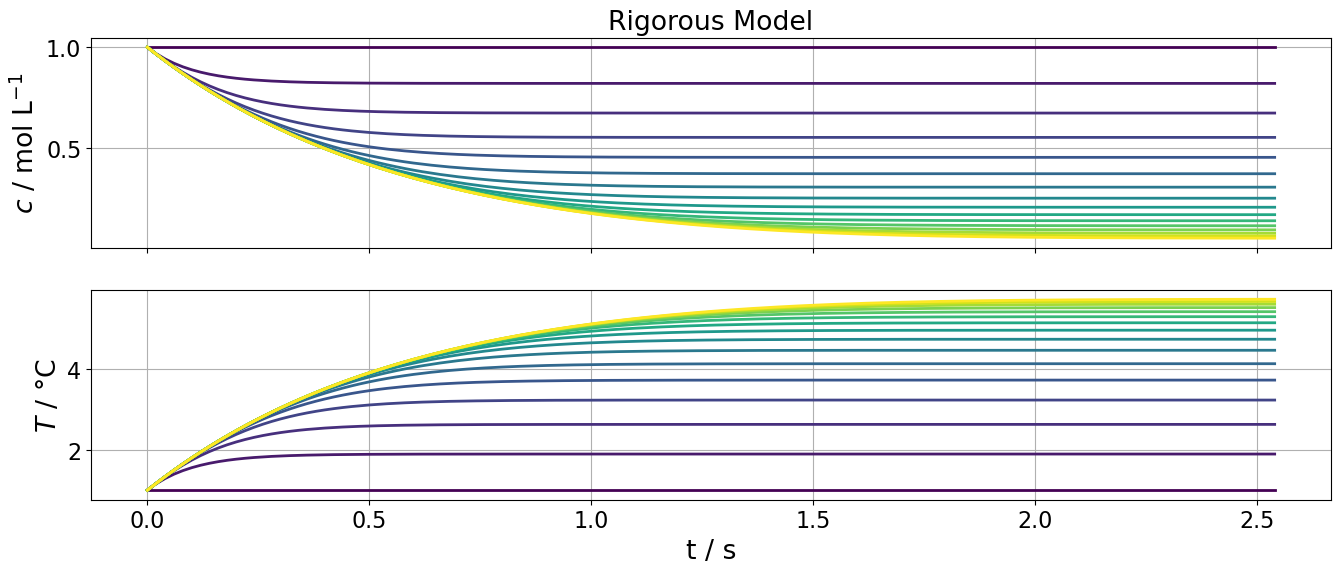

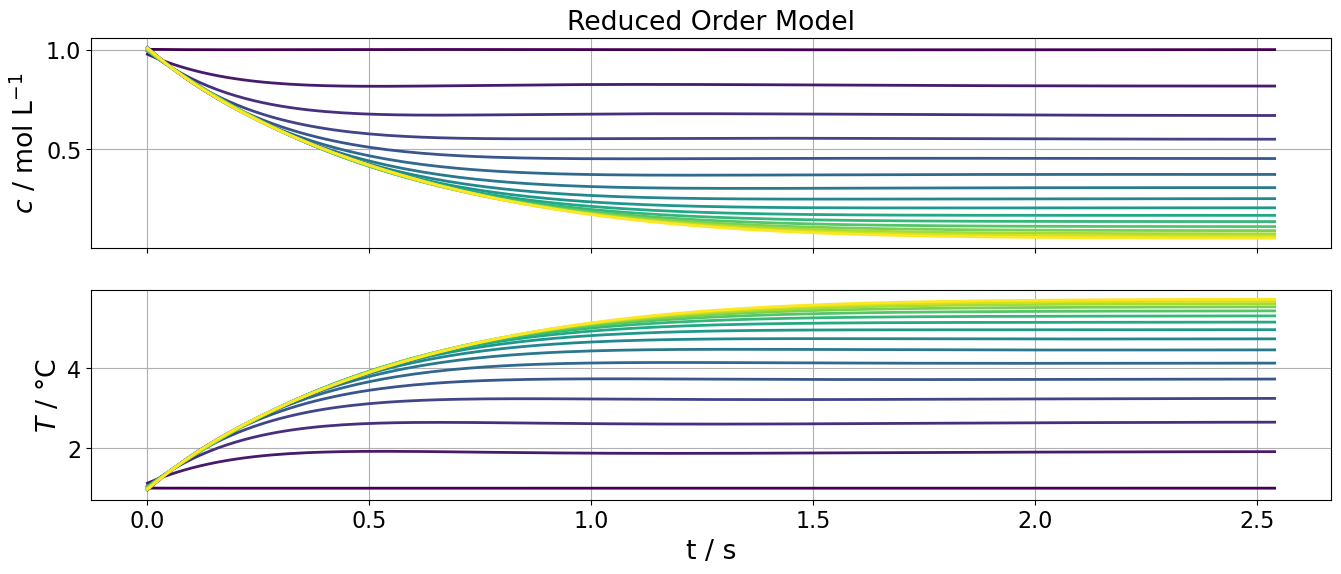

In [75]:
from do_mpc.graphics import Graphics
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update(
    {
        "lines.linewidth": 2,
        "font.size": 16,
        "axes.labelsize": "large",
        "figure.figsize": (10, 6),
        "axes.grid": True,
        "lines.markersize": 10,
        "axes.unicode_minus": False,
        "ps.fonttype": 42,  # Avoid type 3 fonts
        "pdf.fonttype": 42,  # Avoid type 3 fonts
    }
)

rig_graph = Graphics(rigorous_data)
rom_graph = Graphics(rom_data)
fig_full, ax_full = plt.subplots(2, figsize=(16,6), sharex=True)
fig_rom, ax_rom = plt.subplots(2, figsize=(16,6), sharex=True)
cmap = matplotlib.colormaps["viridis"]

for i in range(N_z):
    c = cmap(i / (N_z - 1))
    rig_graph.add_line(
        var_type="_x",
        var_name=f"c_{i}",
        axis=ax_full[0],
        color=c,
    )
    rig_graph.add_line(
        var_type="_x",
        var_name=f"T_{i}",
        axis=ax_full[1],
        color=c,
    )
    rom_graph.add_line(
        var_type="_aux",
        var_name=f"c_{i}",
        axis=ax_rom[0],
        color=c,
    )
    rom_graph.add_line(
        var_type="_aux",
        var_name=f"T_{i}",
        axis=ax_rom[1],
        color=c,
    )

ax_full[0].set_title("Rigorous Model")
ax_full[0].set_ylabel("$c$ / mol L$^{-1}$")
ax_full[1].set_ylabel("$T$ / °C")
ax_full[-1].set_xlabel("t / s")
ax_rom[0].set_title("Reduced Order Model")
ax_rom[0].set_ylabel("$c$ / mol L$^{-1}$")
ax_rom[1].set_ylabel("$T$ / °C")
ax_rom[-1].set_xlabel("t / s")

plt.show()

Depending on the parameter $r$, the ROM can portray the original system dynamics better or worse using more or less states in the reduced state space. Feel free to play with it.